In [1]:
import sys
sys.path.append('../src')
from logger import log, debug
from cleaner import clean_corpus_basic
from reader import read_files
from svm_utils import get_best_tokens_dummy, transform_sentence, get_score

from sklearn.utils import shuffle
from sklearn import svm

import numpy as np
import matplotlib.pyplot as plt

import nltk

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/lefunes/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/lefunes/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [60]:
# -------------- Hiperparametros -----------------

min_vector_size, max_vector_size = 5, 15
vector_size_interval = 2
min_each_q, max_each_q  = 10, 100
each_q_interval = 10
min_lenght, max_length = 4, 8
train_to_test = 0.8

In [61]:
# Leemos los archivos
corpus = clean_corpus_basic(read_files("../dataset/", ["negative", "positive"]))

# Filtramos por longitud
debug("[El corpus tiene " + str(len(corpus)) + " rows]")

#corpus["length"] = corpus["content"].map(lambda x: len(x.split(" ")))
#corpus = corpus[(corpus["length"] >= min_lenght) & (corpus["length"] <= max_length)]

debug("[Luego de filtrar el corpus tiene " + str(len(corpus)) + " rows]")

#Shuffleamos el corpus
corpus = shuffle(corpus)
corpus.reset_index(inplace=True, drop=True)


[Leyendo archivos en panda...]
[Archivos Leidos...]
[Usando cleaner basico]
[Limpiando el corpus...]
[Usando 8 threads ...]
[El corpus tiene 20000 rows]
[Luego de filtrar el corpus tiene 20000 rows]


In [50]:
def supertrain(train_set):
    train_set_splitted = np.array_split(train_set, 5)
    max_classifier = (None, 0)

    # la idea es hacer un cross-check, con 5 arrays
    splitted_len = len(train_set_splitted)
    for i in range(splitted_len):
        no_better_count = 0
        for _ in range(20): #Hacemos 20 iteraciones
            if(no_better_count > 5): #Despues de 3 iteraciones sin encontrar mejor, paramos
                break
                
            train_subset = train_set_splitted[0:i] + train_set_splitted[(i + 1): splitted_len]
            train_subset = [item for sublist in train_subset for item in sublist]
            np.random.shuffle(train_subset)

            np.random.shuffle(train_set_splitted[i])
                
            # Creamos el clasificador y lo evaluamos
            unzipped = list(zip(*train_subset)) 
            classifier = svm.SVC(gamma='scale')
            classifier.fit(unzipped[0], unzipped[1])
            acc = get_score(classifier, train_set_splitted[i])

            # Vemos si encontramos un clasificador mejor
            if(acc > max_classifier[1]):
                log("[   Se encontro un clasificador mejor " + str(acc * 100) + "% ]")
                max_classifier = (classifier, acc) # Guardamos el mejor clasificador
            no_better_count += 1 # Si no encontramos mejor, aumentamos en uno

    return max_classifier


In [63]:
results_svm = []

for each_q in range(min_each_q, max_each_q + 1, each_q_interval):
    for vector_size in range(min_vector_size, max_vector_size + 1, vector_size_interval):
        log("[Entrenando con parametro " + str(each_q) + " " + str(vector_size) + "]")
        best_tokens = get_best_tokens_dummy(corpus, each_q)

        corpus["vector"] = corpus["content"].map(lambda x: transform_sentence(x, best_tokens, vector_size))

        # Dividimos el corpus

        subset = corpus[['vector','rate']]
        featuresets = [tuple(x) for x in subset.values]
        train, test = np.split(featuresets, [int(train_to_test * len(featuresets))])
        clasif = supertrain(train)

        real_acc = get_score(clasif[0], test)

        log("[   Accuaracy real " + str(real_acc * 100) + "% ]")

        results_svm.append((each_q, vector_size, real_acc, clasif[0], clasif[1]))
log("[Fin del entrenamiento]")


[Entrenando con parametro 10 5]
[   Se encontro un clasificador mejor 85.59375% ]
[   Se encontro un clasificador mejor 85.625% ]
[   Se encontro un clasificador mejor 86.0% ]
[   Se encontro un clasificador mejor 86.53125% ]
[   Accuaracy real 85.975% ]
[Entrenando con parametro 10 7]
[   Se encontro un clasificador mejor 84.6875% ]
[   Se encontro un clasificador mejor 85.0% ]
[   Se encontro un clasificador mejor 85.3125% ]
[   Accuaracy real 85.2% ]
[Entrenando con parametro 10 9]
[   Se encontro un clasificador mejor 84.5625% ]
[   Se encontro un clasificador mejor 84.75% ]
[   Se encontro un clasificador mejor 84.78125% ]
[   Accuaracy real 84.5% ]
[Entrenando con parametro 10 11]
[   Se encontro un clasificador mejor 83.78125% ]
[   Se encontro un clasificador mejor 83.8125% ]
[   Se encontro un clasificador mejor 83.96875% ]
[   Se encontro un clasificador mejor 84.15625% ]
[   Accuaracy real 83.45% ]
[Entrenando con parametro 10 13]
[   Se encontro un clasificador mejor 83.75%

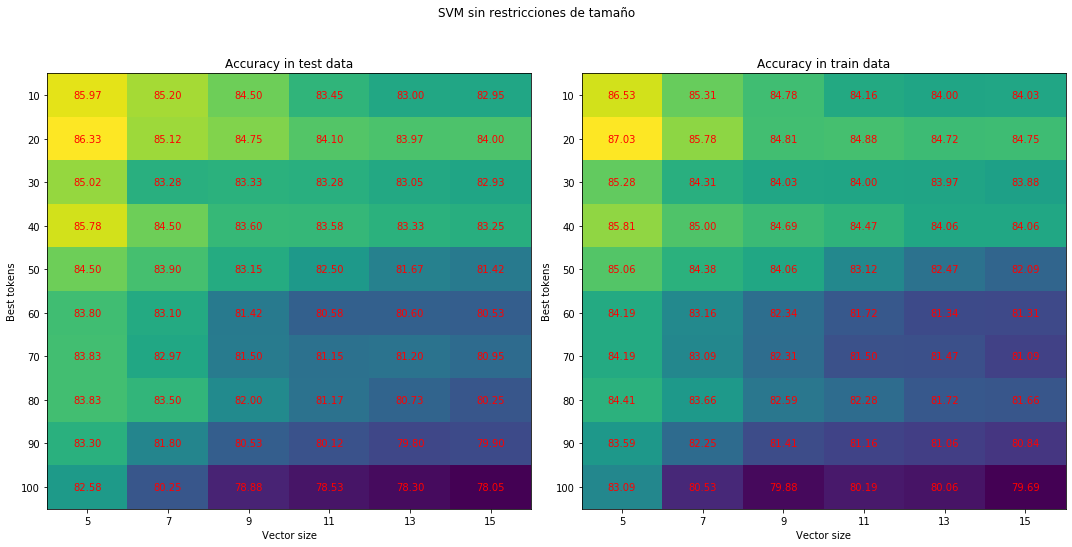

In [65]:
graph_prefix = "no_restricted_svm"


x_labels = []
y_labels = []
i = 0

real_data = []
train_data = []
for each_q in range(min_each_q, max_each_q + 1, each_q_interval):
    real_row = []
    train_row = []
    for vector_size in range(min_vector_size, max_vector_size + 1, vector_size_interval):
        real_row.append(results_svm[i][2])
        train_row.append(results_svm[i][4])
        x_labels.append(results_svm[i][1])
        i +=1
    y_labels.append(results_svm[i - 1][0])
    real_data.append(real_row)
    train_data.append(train_row)
    
x_labels = list( dict.fromkeys(x_labels) )

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15, 7))

fig.suptitle("SVM sin restricciones de tamaño", y=1.08)
im = ax1.imshow(real_data)

ax1.set_xticks(np.arange(len(x_labels)))
ax1.set_yticks(np.arange(len(y_labels)))
ax1.set_xticklabels(x_labels)
ax1.set_yticklabels(y_labels)

for i in range(len(y_labels)):
    for j in range(len(x_labels)):
        text = ax1.text(j, i, '%.2f'%(real_data[i][j] * 100),
                       ha="center", va="center", color="r")

ax1.set_ylim(len(real_data)-0.5, -0.5)

ax1.set_title("Accuracy in test data")
ax1.set_aspect("auto")
ax1.set_xlabel("Vector size")
ax1.set_ylabel("Best tokens")

im = ax2.imshow(train_data)

ax2.set_xticks(np.arange(len(x_labels)))
ax2.set_yticks(np.arange(len(y_labels)))
ax2.set_xticklabels(x_labels)
ax2.set_yticklabels(y_labels)

for i in range(len(y_labels)):
    for j in range(len(x_labels)):
        text = ax2.text(j, i, '%.2f'%(train_data[i][j] * 100),
                       ha="center", va="center", color="r")

ax2.set_ylim(len(real_data)-0.5, -0.5)

ax2.set_title("Accuracy in train data")
ax2.set_aspect("auto")
ax2.set_xlabel("Vector size")
ax2.set_ylabel("Best tokens")


fig.tight_layout()
plt.show()


fig.savefig('./graphs/' + graph_prefix + '.png')

In [ ]:
best_tokens